In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.signal import welch
import warnings
warnings.filterwarnings(action='ignore');

In [2]:
# Rectangular PSD
def Gr(f,f1,p1,f2,p2,A1,A2):
    out = np.zeros(len(f));
    for i in range(len(f)):
        if f[i] >= f1 and f[i] <= p1:
            out[i] = A1
        elif f[i] >= f2 and f[i] <= p2:
            out[i] = A2;
    return out;

In [3]:
# Smooth PSD
def Gs(f,A1,f1,Q1,A2,f2,Q2,fc):
    out1 = np.zeros(len(f)); out2 = np.zeros(len(f));
    for i in range(len(f)):
        if f[i] <= fc:
            out1[i] = A1/np.sqrt(1+((f1-f[i])**2)/(Q1**2));
            out2[i] = A2/np.sqrt(1+((f2-f[i])**2)/(Q2**2));
        else:
            out1[i] = 0;
            out2[i] = 0;
    out = out1 + out2;
    return out

**참고**

Nt, fs, tmax를 아는경우,

dt = 1/fs

Nf = Nt/2

fmax = fs/2

<공식>

Nt * df * dt = 1

In [4]:
# Given PSD
Nt = 2**10; Nf = int(Nt/2);
# Fig 3.7.(a) SP-17 TH
def G1(f):
    A1 = 31000; f1 = 2; p1 = 17; A2 = 5020; f2 = 93; p2 = 132; xm = 0.137; r = 0.270;
    return Gr(f,f1,p1,f2,p2,A1,A2);
def G2(f):
    A1 = 4000; f1 = 2; p1 = 17; A2 = 30801; f2 = 101; p2 = 117; xm = 0.981; r = 0.988;
    return Gr(f,f1,p1,f2,p2,A1,A2);
def G3(f):
    A1 = 27019; f1 = 30; Q1 = 5; A2=20264; f2=104; Q2=2.5; fc = 231; xm=0.493; r=0.600;
    return Gs(f,A1,f1,Q1,A2,f2,Q2,fc);

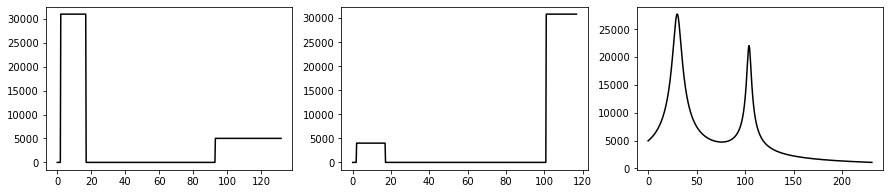

In [5]:
A1 = 31000; f1 = 2; p1 = 17; A2 = 5020; f2 = 93; p2 = 132; xm = 0.137; r = 0.270;
Nt = 1024; Nf = 512; fmax = p2; fs = 2*fmax; dt = 1/fs; tmax = dt*Nt; df = 1/(Nt*dt); 
freq1= np.arange(Nf)*df; psd1 = G1(freq1); grms_spec1 = np.sqrt(A1*(p1-f1)+A2*(p2-f2));
A1 = 4000; f1 = 2; p1 = 17; A2 = 30801; f2 = 101; p2 = 117; xm = 0.981; r = 0.988;
Nt = 1024; Nf = 512; fmax = p2; fs = 2*fmax; dt = 1/fs; tmax = dt*Nt; df = 1/(Nt*dt); 
freq2 = np.arange(Nf)*df; psd2 = G2(freq2); grms_spec2 = np.sqrt(A1*(p1-f1)+A2*(p2-f2));
A1 = 27019; f1 = 30; Q1 = 5; A2=20264; f2=104; Q2=2.5; fc = 231; xm=0.493; r=0.600;
Nt = 1024; Nf = 512; fmax = fc; fs = 2*fmax; dt = 1/fs; tmax = dt*Nt; df = 1/(Nt*dt); 
freq3 = np.arange(Nf)*df; psd3 = G3(freq3);
plt.figure(figsize=(15,3));
plt.subplot(131); plt.plot(freq1,psd1,'k-');
plt.subplot(132); plt.plot(freq2,psd2,'k-');
plt.subplot(133); plt.plot(freq3,psd3,'k-');

In [6]:
def log_interp(x,x_spec,y_spec):
    return 10**np.interp(np.log10(x),np.log10(x_spec),np.log10(y_spec));

In [7]:
def psd2th(freq,psd):  # IFFT method from Dirlik papar
    
    Nt = 1024; Nf = 512;
    fmax = max(freq); df = fmax/Nf;
    dt = 1/Nt/df; tmax = Nt*dt
    fi = np.linspace(df,fmax,Nf);
    G = log_interp(fi,freq,psd);
    F = np.zeros(Nt+1,'complex');
    Phi = np.random.uniform(low=-np.pi,high=np.pi,size=Nf);
    F[Nf+1:] = np.sqrt(G)*np.exp(1j*Phi)
    F[:Nf] = np.conjugate(np.flip(F[Nf+1:]))
    s = np.zeros(20*Nt);
    n = np.arange(-Nf,Nf+1);
    for i in range(20):
        for k in range(Nt):
            s[i*Nt+k] = df*np.sum(F*np.exp(1j*2*np.pi*k*n/Nt))
            
    ti = np.arange(20*Nt)*dt
    
    # grms 맞추는 과정은 내가 추가
    grms_spec = np.sqrt(np.trapz(G,fi));
    grms_syn = np.std(s)
    s *= grms_spec/grms_syn;
    
    return ti,s

In [8]:
def psdinteg(freq,psd):
    f = freq; y = psd;
    ndata = len(y);
    a = np.zeros(ndata-1);
    for i in range(ndata-1):
        n = np.log10(y[i+1]/y[i])/np.log10(f[i+1]/f[i]);
        if n == -1:
            a[i] = y[i]*f[i]*np.log(f[i+1]/f[i]);
        else:
            a[i] = (y[i]/(f[i]**n))*(1/(n+1))*(f[i+1]**(n+1)-f[i]**(n+1));
    return np.sqrt(sum(a))

spec grms = 812.88  syn grms = 805.65


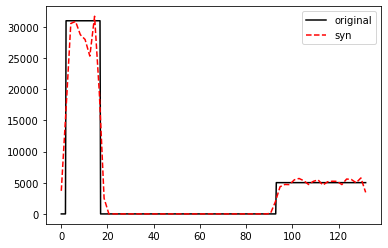

In [9]:
# PSD1
time,th = psd2th(freq1,psd1);
# grms 비교
grms_syn = np.std(th);
print("spec grms = %.2f  syn grms = %.2f"%(grms_spec1,grms_syn));
# PSD Check
freq_syn,psd_syn = welch(th,fs = max(freq1)*2,nperseg=2**7);
plt.plot(freq1,psd1,'k-',label='original');
plt.plot(freq_syn,psd_syn,'r--',label='syn'); plt.legend(loc='upper right');

spec grms = 743.52  syn grms = 739.95


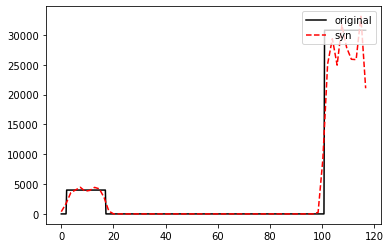

In [10]:
# PSD2
time,th = psd2th(freq2,psd2);
# grms 비교
grms_syn = np.std(th);
print("spec grms = %.2f  syn grms = %.2f"%(grms_spec2,grms_syn));
# PSD Check
freq_syn,psd_syn = welch(th,fs = max(freq2)*2,nperseg=2**7);
plt.plot(freq2,psd2,'k-',label='original');
plt.plot(freq_syn,psd_syn,'r--',label='syn'); plt.legend(loc='upper right');

spec grms = 1177.62  syn grms = 1176.66


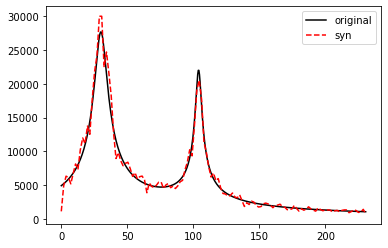

In [11]:
# PSD3
time,th = psd2th(freq3,psd3);
# grms 비교
grms_spec = psdinteg(freq3,psd3); grms_syn = np.std(th);
print("spec grms = %.2f  syn grms = %.2f"%(grms_spec,grms_syn));
# PSD Check
freq_syn,psd_syn = welch(th,fs = max(freq3)*2,nperseg=2**8);
plt.plot(freq3,psd3,'k-',label='original');
plt.plot(freq_syn,psd_syn,'r--',label='syn'); plt.legend(loc='upper right');